In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf
from sklearn.feature_selection import mutual_info_regression

[0.17886346308111456, 0.17866747847110886, 0.17962531765201284, 0.17859113311568375, 0.17968676116270643, 0.18134591685559975, 0.18092331744723467, 0.18107755366259237, 0.1814915042963161, 0.18085510468809307, 0.18131325011881838, 0.18186459031949465, 0.18138164717028626, 0.1822159783397197, 0.18075488540240148, 0.18225288709381804, 0.18231470328687926, 0.18385339547470902, 0.1831559419106501, 0.18452151046404985, 0.18384397612951098, 0.18309305463730396, 0.18427290175848476, 0.18442841815746025, 0.18506036430349226, 0.18396412234914372, 0.1843560460012199, 0.18471499784047474, 0.18542676192432594, 0.18416453884773976, 0.18659903642105657, 0.18657744966020395, 0.18575340731557954, 0.18649403757995398, 0.18734694014378217, 0.18867522397212877, 0.18892641816219236, 0.189253354312795, 0.19007427549652434, 0.18997010817702265, 0.1911309625305302, 0.1907644302002005, 0.19089363324449593, 0.1918831117194797, 0.19253253982218155, 0.1944825432730033, 0.19349430262418554, 0.1939112632907909, 0.

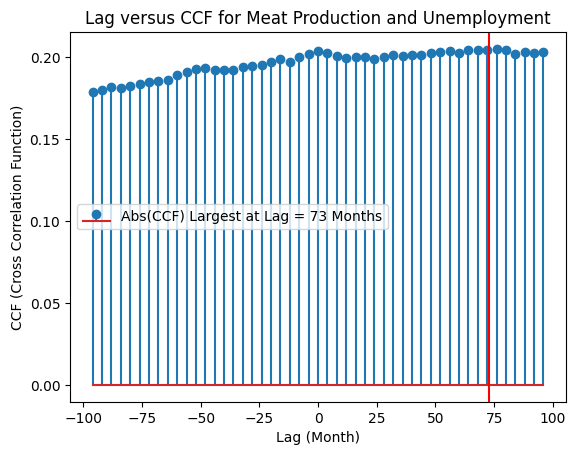

In [5]:
production_df = pd.read_csv('../cleaned-datasets/Cleaned_Meat_Stats_Meat_Production.csv')
economic_df = pd.read_csv('../cleaned-datasets/interpolated_economic_data.csv')
economic_df['Date'] = economic_df['date']

# Averaging data from top meatpacking and poultry processing states into one data point per year
condition_1_states = ["Nebraska", "Iowa", "Texas", "Kansas", "Illinois"]
condition_1 = economic_df["state"].isin(condition_1_states)
condition_2_states = ["Georgia", "Arkansas", "North Carolina", "Alabama", "Mississippi"]
condition_2 = economic_df['state'].isin(condition_2_states)
new_economic_df = economic_df[condition_1 | condition_2].copy()

# Merge datasets on 'Year'
data = pd.merge(production_df, new_economic_df, on='Date')
data.set_index('Date')

# Create an array of lag values
num = 96
lags = np.arange(-num, num + 1)

# aux fn for application
def gen_corr(l1, l2, lag: int) -> float:
    # Positive shift means front becomes NaN, negative shift means end becomes NaN
    if lag < 0:
        shifted_l1 = l1.copy().shift(-lag).dropna() 
        aligned_l2 = l2[:len(shifted_l1)] # align l2 to be the same length as l1
    else:
        shifted_l1 = l1.copy().shift(-lag).dropna() 
        aligned_l2 = l2[lag:]
        aligned_l2 = aligned_l2[:len(shifted_l1)] # Just in case?
        
    return mutual_info_regression(shifted_l1.values.reshape(-1, 1), aligned_l2.values)[0]
    
    # return mutual_info_regression(
    #     l1.shift(lag).dropna().values.reshape(-1, 1), l2.values[:-lag]
    # )
    
# generate correlations
# corr = [gen_corr(data['unemployment_rate'], data['Production'], -lag) for lag in lags if lag <= 0]
# corr += [gen_corr(data['Production'], data['unemployment_rate'], lag) for lag in lags if lag > 0]
corr = [gen_corr(data['unemployment_rate'], data['Production'], lag) for lag in lags]

# # Calculating cross-correlation for negative lags
# neg_ccf = ccf(data['unemployment_rate'], data['Production'])
# neg_ccf = neg_ccf[:num + 1][::-1]

# # Combine with non-negative lags
# pos_ccf = ccf(data['Production'], data['unemployment_rate'])
# all_ccf = list(neg_ccf) + list(pos_ccf[1:num + 1])

all_ccf = corr

print(all_ccf)

max_index = 0
for i in range(0, len(all_ccf)):
    if abs(all_ccf[i]) > abs(all_ccf[max_index]):
        max_index = i
print(max_index - num, all_ccf[max_index])

# Slice the arrays to make the graph less overwhelming
lags_sliced = lags[::4]
ccf_sliced = all_ccf[::4]

plt.stem(lags_sliced, ccf_sliced, label=f'Abs(CCF) Largest at Lag = {max_index - num} Months')
plt.xlabel('Lag (Month)')
plt.ylabel('CCF (Cross Correlation Function)')
plt.axvline(x=max_index - num, color="red")
# plt.ylim(-0.12, -0.08)
# plt.yticks(np.arange(-0.11, -0.08, 0.01)) # set y-axis ticks at intervals
plt.title('Lag versus CCF for Meat Production and Unemployment')
plt.legend()
plt.savefig('../visualizations/Lag Correlation Coefficients - MIR.png', dpi=400)
plt.show()